In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import os
print(os.listdir("../input"))

['champs-scalar-coupling', 'prepare-dataset-rdkit-rev-2']


In [3]:
#Load sub data
mol_dataset= pd.read_csv("../input/prepare-dataset-rdkit-rev-2/mol_dataset.csv")
mol_dataset.head(5)

,molecule_name,mol_data,smiles,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,dsgdb9nsd_000001,<rdkit.Chem.rdchem.Mol object at 0x7f2e531d1c60>,C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,dsgdb9nsd_000002,<rdkit.Chem.rdchem.Mol object at 0x7f2e531d1da0>,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,dsgdb9nsd_000003,<rdkit.Chem.rdchem.Mol object at 0x7f2e52743f80>,O,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,dsgdb9nsd_000005,<rdkit.Chem.rdchem.Mol object at 0x7f2e531d1e90>,C#N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,dsgdb9nsd_000007,<rdkit.Chem.rdchem.Mol object at 0x7f2e531d1f30>,CC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

#reduce data size
mol_dataset = reduce_mem_usage(mol_dataset)

Mem. usage decreased to 60.74 Mb (83.5% reduction)


In [5]:
#cut string data
mol_all = mol_dataset.iloc[:,3:370]
mol_all.head(5)

#mol_fingerprint = mol_dataset.iloc[:,3:170]
#mol_fingerptint.shape

#mol_descriptor = mol_dataset.iloc[:,171:370]
#mol_descriptor.shape

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#EDA

In [6]:
mol_all.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,130775.0,130775.0,130775.0,130775.0,130775.0,130775.0,130775.0,130775.0,130775.000000,130775.0,130775.0,130775.000000,130775.0,130775.0,130775.0,130775.000000,130775.000000,130775.000000,130775.0,130775.000000,130775.0,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.0,130775.000000,130775.0,130775.0,130775.0,130775.0,130775.0,130775.0,130775.0,130775.0,130775.000000,130775.000000,130775.0,...,130775.0,130775.000000,130775.000000,130775.000000,130775.0,130775.0,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.0,130775.0,130775.000000,130775.000000,130775.000000,130775.0,130775.000000,130775.000000,130775.0,130775.0,130775.0,130775.000000,130775.000000,130775.0,130775.0,130775.0,130775.000000,130775.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.225326,0.0,0.0,0.386603,0.0,0.0,0.0,0.002378,0.213825,0.134437,0.0,0.158302,0.0,0.000474,0.417817,0.015056,0.015232,0.010453,0.012587,0.0,0.010162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030250,0.070365,0.0,...,0.0,0.000054,0.017847,0.005200,0.0,0.0,0.118899,0.109631,0.013925,0.022390,0.067100,0.022695,0.132158,0.000994,0.000008,0.000008,0.000260,0.013206,0.013886,0.000619,0.000986,0.000979,0.0,0.0,0.095783,0.008358,0.023636,0.0,0.008060,0.001583,0.0,0.0,0.0,0.107941,0.002432,0.0,0.0,0.0,0.023284,0.008977
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.417798,0.0,0.0,0.486973,0.0,0.0,0.0,0.048708,0.410006,0.341123,0.0,0.365026,0.0,0.021769,0.493202,0.121778,0.122476,0.101705,0.111482,0.0,0.100296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.171276,0.255762,0.0,...,0.0,0.007316,0.133376,0.077648,0.0,0.0,0.338950,0.325966,0.117179,0.154817,0.256772,0.171996,0.357106,0.031513,0.002765,0.002765,0.016122,0.114691,0.117672,0.028058,0.038004,0.037903,0.0,0.0,0.437039,0.128336,0.154211,0.0,0.089413,0.039754,0.0,0.0,0.0,0.328013,0.049407,0.0,0.0,0.0,0.216825,0.095611
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0

There are a lot of 0 or 1 data, and no variance columns.  
In addition, low std columns means that there are high bias of data. If this bias is too high, sometime set up bad effect when do CV. If we do 5-fold CV, we sould remove the columns which contain over 80% same data such as 0, 1.

reference:  
https://datachemeng.com/deletedescriptors/  
https://datachemeng.com/wp-content/uploads/2017/09/basicdatapreprocessing.pdf

![](http://)

In [7]:
#omit too low std  columns
mol_high_std=mol_all.loc[:, abs(mol_all.describe().loc['std']) > 0.0001]
mol_high_std.describe()

,8,11,15,16,17,19,21,22,23,24,25,26,28,37,38,41,42,43,45,49,50,52,53,54,56,57,62,63,65,66,69,70,71,72,74,75,76,77,78,79,...,fr_aryl_methyl,fr_azo,fr_benzene,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzone,fr_imidazole,fr_imide,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_piperdine,fr_piperzine,fr_priamide,fr_pyridine,fr_quatN,fr_term_acetylene,fr_tetrazole,fr_unbrch_alkane,fr_urea
count,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,...,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000,130775.000000
mean,0.225326,0.386603,0.002378,0.213825,0.134437,0.158302,0.000474,0.417817,0.015056,0.015232,0.010453,0.012587,0.010162,0.030250,0.070365,0.125880,0.014582,0.033493,0.013175,0.003670,0.049719,0.055798,0.106848,0.097282,0.001048,0.404642,0.039786,0.001254,0.152590,0.401155,0.041376,0.025265,0.046232,0.220294,0.057710,0.085276,0.054276,0.131814,0.137710,0.166683,...,0.068561,0.000107,0.002225,0.505731,0.000122,0.000008,0.081269,0.035297,0.523135,0.011332,0.001713,0.022910,0.000054,0.017847,0.005200,0.118899,0.109631,0.013925,0.022390,0.067100,0.022695,0.132158,0.000994,0.000008,0.000008,0.000260,0.013206,0.013886,0.000619,0.000986,0.000979,0.095783,0.008358,0.023636,0.008060,0.001583,0.107941,0.002432,0.023284,0.008977
std,0.417798,0.486973,0.048708,0.410006,0.341123,0.365026,0.021769,0.493202,0.121778,0.122476,0.101705,0.111482,0.100296,0.171276,0.255762,0.331716,0.119874,0.179920,0.114025,0.060473,0.217365,0.229532,0.308921,0.296342,0.032350,0.490824,0.195457,0.035391,0.359594,0.490134,0.199160,0.156929,0.209988,0.414447,0.233195,0.279293,0.226563,0.338290,0.344596,0.372694,...,0.289144,0.011061,0.047120,0.882482,0.011731,0.002765,0.284223,0.185770,0.652054,0.106569,0.042266,0.214686,0.007316,0.133376,0.077648,0.338950,0.325966,0.117179,0.154817,0.256772,0.171996,0.357106,0.031513,0.002765,0.002765,0.016122,0.114691,0.117672,0.028058,0.038004,0.037903,0.437039,0.128336,0.154211,0.089413,0.039754,0.328013,0.049407,0.216825,0.095611
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

156 columns were omitted.

In [8]:
import pandas_profiling as pdp

In [9]:
pdp.ProfileReport(mol_high_std)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/opt/conda/lib/python3.6/site-packages/pandas/core/internals.py:389: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  self.values = np.delete(self.values, loc, 0)
/opt/conda/lib/python3.6/site-packages/pandas/core/internals.py:390: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  self.mgr_locs = self.mgr_locs.delete(loc)
/opt/conda/lib/python3.6/site-packages/pandas/core/internals.py:389: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  self.values = np.delete(self.values, loc, 0)
/opt/conda/lib/python3.6/site-packages/pandas/core/internals.py:390: Fu

ValueError: Wrong number of items passed 209, placement implies 207

There are a lot of information for analysis.  
The important information are following:    
1. 11528 rows duplicate.  
2. high correlation peers(column name) are following (need blocking):  
    - 71-102  
    - 42-107-134  
    - 66-112  
    - 110-117  
    - 78-119
    - 85-122-148
    - 94-124
    - 70-130
    - 127-143
    - 65-162-NumAromaticHeterocycles-NumAromaticRings
    - 50-76
    - NOCount-NumHAcceptors (r=0.91896)-NumHeteroatoms(r=0.90326)
    - NHOHCount-NumHDonors
    - NumAliphaticCarbocycles-NumSaturatedCarbocycles-NumSaturatedHeterocycles
    - NumAliphaticRings-NumSaturatedRings-RingCount(r=0.90363)
    - fr_Al_COO-fr_COO-fr_COO2
    - fr_C_O-fr_C_O_noCOO
    - 84-fr_NH2
    - fr_Ar_NH-fr_Nhpyrrole
    - fr_benzene-NumAromaticCarbocycles
    - 41-fr_nitrile
    - 56-fr_nitro
    - fr_nitro_arom-fr_nitro_arom_nonortho
    - 24-fr_oxime
    - fr_phenol-fr_phenol_noOrthoHbond
    
3. too high bias columns are following(0/1 ratio over 50):
    - 166 :only one row is 1, the others are 0.
    - 15 :only 15 rows are 1, the others are 0.
    - 125 :only 879 rows are 1, the others are 0.
    - 21 :only 62 rows are 1, the others are 0.
    - 23 :only 1969 rows are 1, the others are 0.
    - 24 :only 1992 rows are 1, the others are 0.
    - 25 :only  1367 rows are 1, the others are 0.
    - 26 :only 1646 rows are 1, the others are 0.
    - 28 :only 1329 rows are 1, the others are 0.
    - 42 :only 1907 rows are 1, the others are 0.
    - 45 :only 1723 rows are 1, the others are 0.
    - 49 :only 480 rows are 1, the others are 0.
    - 56 :only 137 rows are 1, the others are 0.
    - 63 :only 164 rows are 1, the others are 0.
    - 87 :only 1468 rows are 1, the others are 0.
    - NumAromaticCarbocycles :only 304 rows are 1, the others are 0.
    - fr_Al_OH :only 190 rows are 1, the others are 0.
    - fr_Ar_COO :only one row is 1, the others are 0.
    - fr_HOCCN : 99.4% of data are zero.
    - fr_alkyl_carbamate :only 495 rows are 1, the others are 0.
    - fr_alkyl_halide :99.7% of data are zero.
    - fr_azo :near 100% of data are zero.
    - fr_diazo :near 100% of data are zero.
    - fr_dihydropyridine :only one row is 1, the others are 0.
    - fr_furan :98.9% of data are zero.
    - fr_guanido :99.8% of data are zero.
    - fr_hdrzone :only 7 rows are 1, the others are 0.
    - fr_imidazole :98.2% of data are zero.
    - fr_imide :99.5% of data are zero.
    - fr_lactam :only 1821 rows are 1, the others are 0.
    - fr_morpholine :98.0% of data are zero.
    - fr_nitro_arom :only one row is 1, the others are 0.
    - fr_nitroso :only 34 rows are 1, the others are 0.
    - fr_oxazole :98.7% of data are zero.
    - fr_para_hydroxylation :99.9% of data are zero.
    - fr_phenol :99.9% of data are zero.
    - fr_piperzine :99.4% of data are zero.
    - fr_pyridine :only 1054 rows are 1, the others are 0.
    - fr_quatN :only 207 rows are 1, the others are 0.
    - fr_tetrazole :99.8% of data are zero.
    - fr_unbrch_alkane :98.5% of data are zero.
    - fr_urea :99.1% of data are zero.

we need to consider how to deal them.....  

In this time, I pro-process as follows:

- Action for list 1. data : Stay
- Action for list 2. variables : When blocking , left side variable stay and the others omit (Actually speaking I need to do more carefully to bloking but this time do rough)
- Acition for list 3. variables : All of them omit

In [10]:
#blocking
drop_mol =mol_high_std.drop(["102", "107","134","112", "117","119","122", "148","124","130", "143","162", "76",
                 "NumAromaticHeterocycles","NumAromaticRings","NumHAcceptors","NumHeteroatoms", "NumHDonors",
                 "NumSaturatedCarbocycles","NumSaturatedHeterocycles", "NumSaturatedRings","RingCount","fr_COO", 
                 "fr_COO2","fr_C_O_noCOO","fr_NH2", "fr_Nhpyrrole","NumAromaticCarbocycles","fr_nitrile", 
                 "fr_nitro","fr_nitro_arom_nonortho","fr_oxime", "fr_phenol_noOrthoHbond"] , axis=1)

In [11]:
#omit high bias varibles
drop_mol=drop_mol.drop(["166","15","125","21","23","24","25","26","28","42","45","49","56","63","87",
                        "fr_Al_OH","fr_Ar_COO","fr_HOCCN","fr_alkyl_carbamate","fr_alkyl_halide",
                        "fr_azo","fr_diazo","fr_dihydropyridine","fr_furan","fr_guanido","fr_hdrzone","fr_imidazole",
                        "fr_imide","fr_lactam","fr_morpholine","fr_nitro_arom","fr_nitroso","fr_oxazole","fr_para_hydroxylation",
                        "fr_phenol","fr_piperzine","fr_pyridine","fr_quatN","fr_tetrazole","fr_unbrch_alkane","fr_urea"], 
                       axis=1)

In [12]:
drop_mol.head()

,8,11,16,17,19,22,37,38,41,43,50,52,53,54,57,62,65,66,69,70,71,72,74,75,77,78,79,80,82,83,84,85,86,89,90,91,92,93,94,95,...,SlogP_VSA7,VSA_EState9,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumRotatableBonds,fr_Al_COO,fr_Al_OH_noTert,fr_ArN,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_C_O,fr_Imine,fr_NH0,fr_NH1,fr_Ndealkylation1,fr_Ndealkylation2,fr_aldehyde,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_benzene,fr_bicyclic,fr_epoxide,fr_ester,fr_ether,fr_halogen,fr_ketone,fr_ketone_Topliss,fr_lactone,fr_methoxy,fr_piperdine,fr_priamide,fr_term_acetylene
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
drop_mol.shape

(130775, 144)

OK, now 367 comlums become only 144 columns after rough pre-processing.

#Kernel PCA

Reference:  
https://blog.shikoan.com/kernel-pca-explained-variance-ratio/

In [14]:
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [15]:
#reduce memory load
#devide and random sumpling
drop_mol_half1,drop_mol_half2  = train_test_split(drop_mol, test_size=0.8)
drop_mol_half1.head()

,8,11,16,17,19,22,37,38,41,43,50,52,53,54,57,62,65,66,69,70,71,72,74,75,77,78,79,80,82,83,84,85,86,89,90,91,92,93,94,95,...,SlogP_VSA7,VSA_EState9,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumRotatableBonds,fr_Al_COO,fr_Al_OH_noTert,fr_ArN,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_C_O,fr_Imine,fr_NH0,fr_NH1,fr_Ndealkylation1,fr_Ndealkylation2,fr_aldehyde,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_benzene,fr_bicyclic,fr_epoxide,fr_ester,fr_ether,fr_halogen,fr_ketone,fr_ketone_Topliss,fr_lactone,fr_methoxy,fr_piperdine,fr_priamide,fr_term_acetylene
70887,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,1,1,0,0,1,...,0.0,0.000000,9,1,3,1,1,2,1,0,0,0,0,0,0,1,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
87288,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,1,0,0,...,0.0,1.518555,8,2,4,0,0,0,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,1,0,1,0
124943,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,...,0.0,1.710938,9,1,2,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
19517,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,1,...,0.0,3.326172,9,1,3,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
49944,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,...,0.0,0.000000,9,0,1,2,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,1,0,0,0,0,0,0,0,0


(26155, 2)
Explained var ratio : 0.0003301594699032708


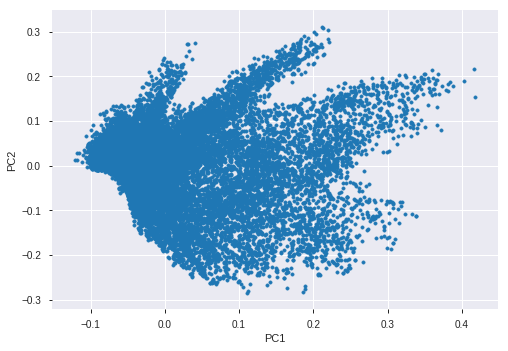

In [16]:
kpca = KernelPCA(n_components=2,kernel='rbf',gamma=0.1)
res = kpca.fit_transform(drop_mol_half1)

print(res.shape)

pc = res.T

print("Explained var ratio :", np.sum(np.var(res, axis=0) / np.sum(np.var(drop_mol_half1, axis=0)))) #maybe not proper explanation
#print("Explained var score :", explained_variance_score(drop_mol_half1, kpca.inverse_transform(res)))

plt.figure()
plt.scatter(pc[0], pc[1], marker=".")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
#plt.savefig("pca_plot.png")